### Replicating a ML research paper 

#### Vision Transformers ---> https://arxiv.org/abs/2010.11929

In [1]:
## Importing packages and scripts

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/vishal./ViT-replication-using-PyTorch/')
sys.path.insert(2, '/Users/vishal./ViT-replication-using-PyTorch/')
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary
import random
import matplotlib.pyplot as plt
from going_modular import data_setup,engine

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
### Get Data

import os 
import zipfile
from pathlib import Path

import requests

# Setup Data Path
data_path= Path("/Users/vishal./ViT-replication-using-PyTorch/data/")
image_path= data_path/"pizza_steak_sushi"

# If the image folder doesnt exist download it from the internet and prepare it 

if image_path.is_dir():
    print(f"{image_path} directory exists,skipping data")
   
else:
    print(f"Did not find {image_path}")
    image_path.mkdir(parents=True,exist_ok=True)

    with open(data_path/"pizza_steak_sushi.zip","wb") as f:
        request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading Data...")
        f.write(request.content)

    # Unzip the data
    with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip","r") as zip_ref:
        print("unzipping the data")
        zip_ref.extractall(image_path)
    os.remove(data_path/"pizza_steak_sushi.zip")


/Users/vishal./ViT-replication-using-PyTorch/data/pizza_steak_sushi directory exists,skipping data


In [4]:
# Get the data

# specify the directory
train_dir= f"{image_path}/train"
test_dir= f"{image_path}/test"
train_dir,test_dir

('/Users/vishal./ViT-replication-using-PyTorch/data/pizza_steak_sushi/train',
 '/Users/vishal./ViT-replication-using-PyTorch/data/pizza_steak_sushi/test')

In [5]:
### Setup the transform according the paper

IMG_SIZE=224 # Table 3 from the ViT paper

manual_transforms= transforms.Compose([transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
                                       transforms.ToTensor()
                                       ])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [6]:
## Create DataLoaders

BATCH_SIZE=32 # The paper uses 4096, may be be too big for our hardware let's use 32 and scale up when needed

train_dataloader,test_dataloader,num_classes= data_setup.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=manual_transforms,
                                                                            batch_size=BATCH_SIZE)

train_dataloader,test_dataloader,num_classes

(<torch.utils.data.dataloader.DataLoader at 0x16a1d3a90>,
 ['pizza', 'steak', 'sushi'])

In [7]:
len(train_dataloader),len(test_dataloader),num_classes

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# Check the length of the dataloaders and the lables

sample_img,sample_label= next(iter(train_dataloader))
img,label= sample_img[1],sample_label[1]
img.shape,label

(torch.Size([3, 224, 224]), tensor(0))

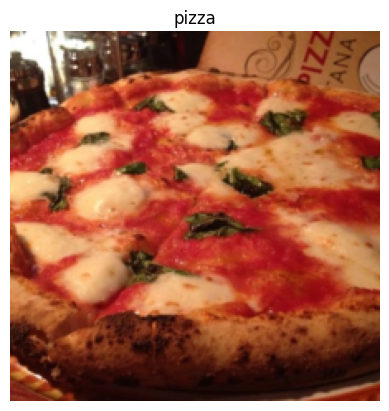

In [9]:
plt.imshow(img.permute(1,2,0));
plt.title(num_classes[label]);
plt.axis(False);

#### Replicating ViT: Overview 

Break down the research paper into smaller pieces: 

* **Input** : What goes into the model?
* **Output** : What does the model output?
* **Layer** : Takes an input manipulates it with a function (self-attention,conv,or maxpool etc)
* **Blocks** : Collection of layers
* **Model** : Collection of blocks

#### ViT Architecture Overview

![](ViT_architecture.png)

#### Let's breakdown the ViT architecture into equations

![](ViT_equations.png)



#### First Equation: Input
 
x1_p,x2_p,....xn_p ----> Images patches with size 16 x 16

x1_pE,x2_pE,.....xn_pE -----> Images patches converted into path embeddings

x_class -----> The learnable classification token

E_pos -----> Position Embedding


![](ViT_Equation1_1.png)

![](ViT_Equation1_2.png)

In pseudocode:

```python
x_input = [class_token, image_patch1,image_patch2,....image_patchN] + [class_token_pos,image_patch1_pos....image_patchn_pos]
```


#### Second & Thrid Equation: Multi-Head Self-Attention and MLP


![](ViT_Equation2&3.png)

```python
# Equation 2
x_output_MSA_block= MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block= mlp_LAYER(LN_layer(x_output)) + x_output_MSA_block
```


#### Fourth Equation: Output

![](ViT_Equation4.png)

pesudocode:

```python
# Equation 4
y = Linear_Layer(LN_layer(x_output_MLP_block)) 
```

#### Model Variants Table

![](ViT_model_variants.png)


* All the variants have the same model architecture, but vary in layers
* Layers- the number of transformer encoder layer
* Hidden Size $D$ - the embedding size throughout the architecture
* MLP - No: of hidden units in MLP
* Head - No: of multi-head self attention in the MSA block

#### Implementing Equation 1

Input Shape: H x W x C (height x width x color_channels)

Output Shape: N x (P^2 . C)

* H = height
* W = width
* C = color channels 
* P = patch size
* N = number of patches = (height*width)/P**2
* D = constant latent vector = embedding dimension 

In [10]:
height= 224
width =224
color_channels= 3
patch_size= 16

no_of_patches = int((height * width)/ patch_size**2)
no_of_patches

196

In [11]:
# Calculating input and output shapes

embedding_layer_input_shape = (height,width,color_channels)

embedding_layer_output_shape= (no_of_patches,(patch_size**2 * color_channels)) 

print(f"Input Embedding Size (single 2D Image): {embedding_layer_input_shape}")
print(f"Output Embedding Size (sequence of patches): {embedding_layer_output_shape}") # (number of patches,embedding dimension)

Input Embedding Size (single 2D Image): (224, 224, 3)
Output Embedding Size (sequence of patches): (196, 768)


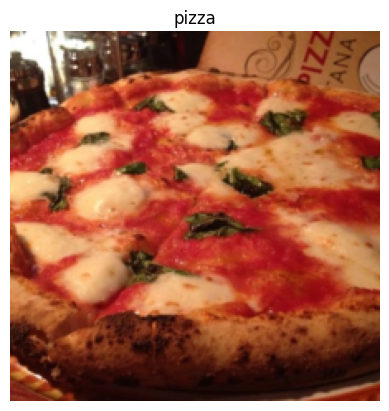

In [12]:
### Turning a single image into patches 

plt.imshow(img.permute(1,2,0))
plt.title(num_classes[label])
plt.axis(False);

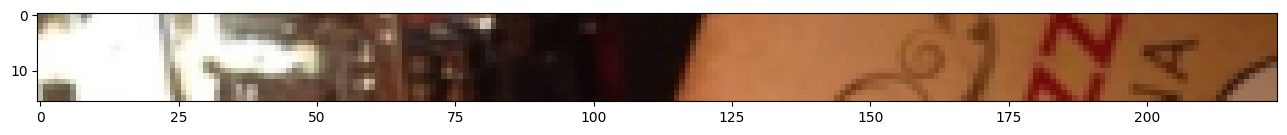

In [13]:
image_permuted= img.permute(1,2,0)
nrow= 16
ncolumn=16
patch_size=16

plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

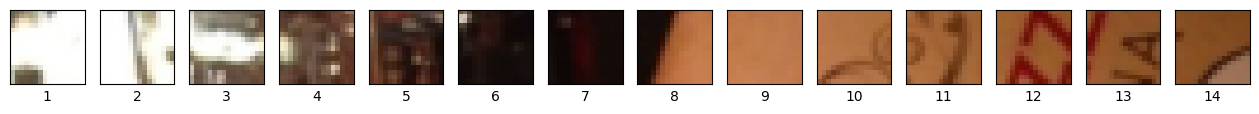

In [14]:
# Setup up patches for the top row of the image
img_size=224
patch_size=16
num_patches= img_size/patch_size
assert img_size % patch_size==0,"Image size must be divisble by patch size"

fig,axs= plt.subplots(nrows=1,
                      ncols=img_size//patch_size,
                      sharex=True,sharey=True,
                      figsize=(patch_size,patch_size)) 

# Iterate through number of patches in the top row

for i,patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Text(0.5, 0.98, 'pizza --> Patchified')

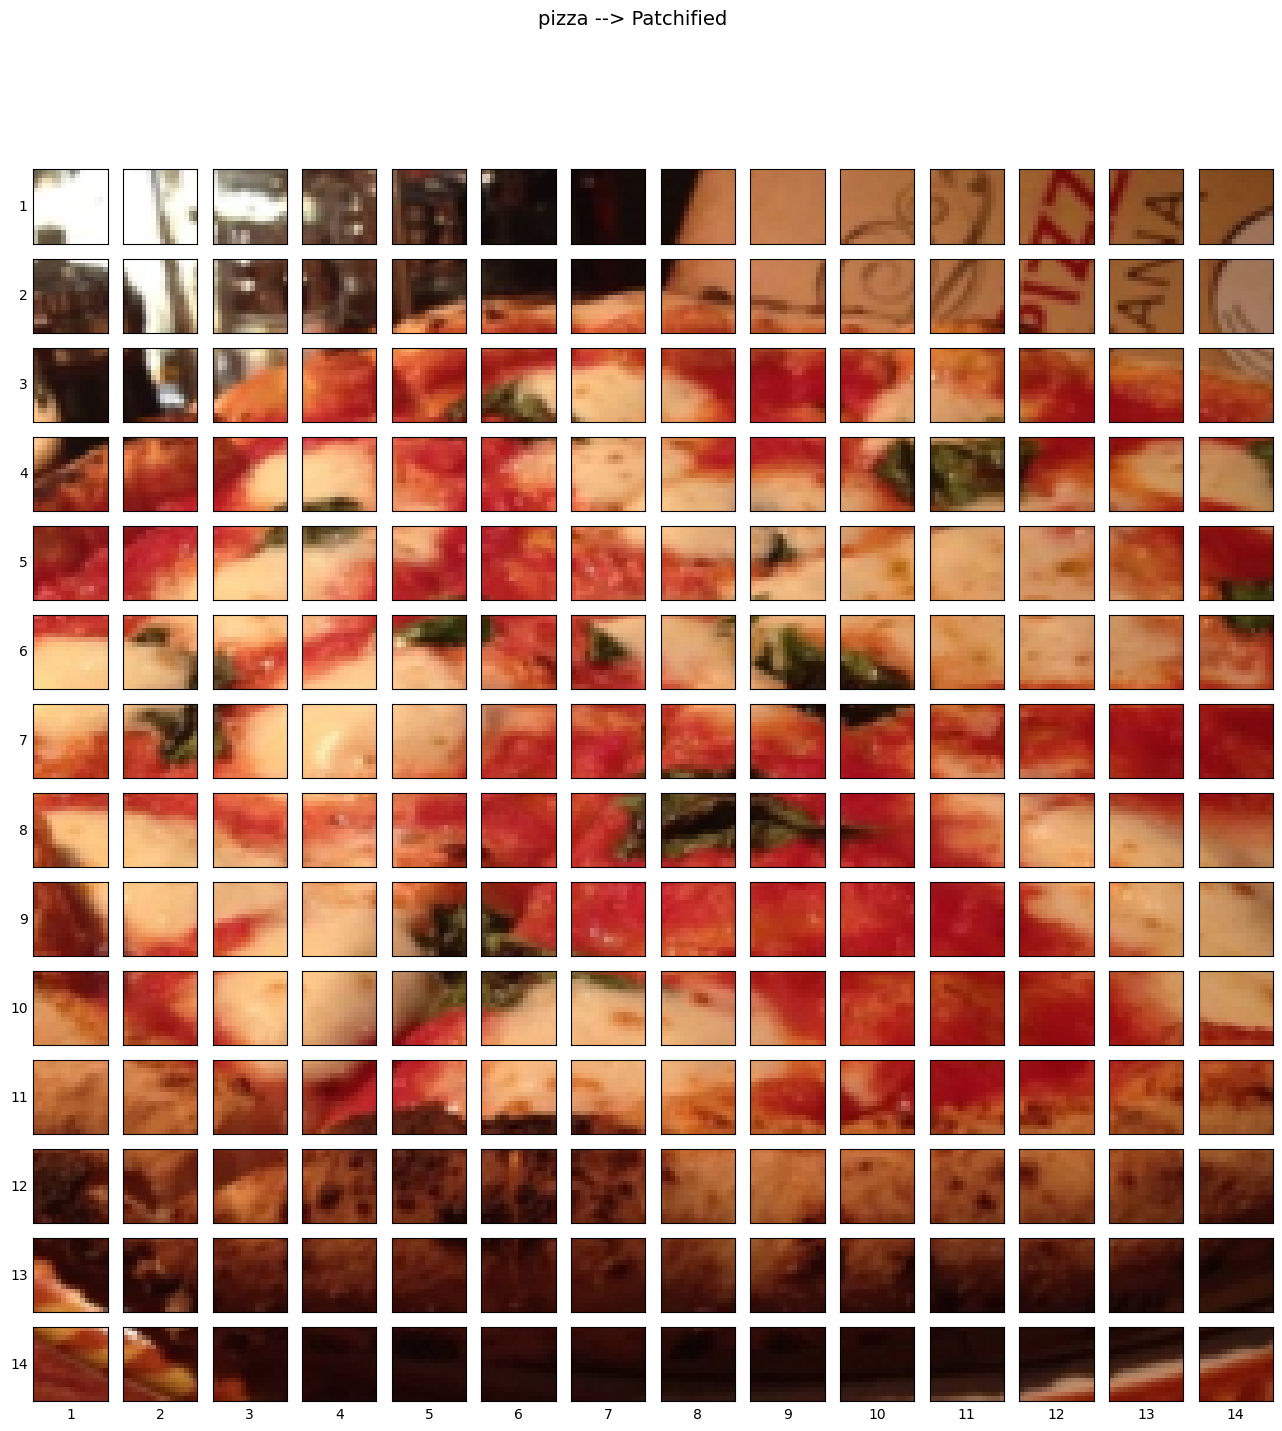

In [15]:
# Setup up patches for the entire image
img_size=224
patch_size=16
num_patches= img_size/patch_size
assert img_size % patch_size==0,"Image size must be divisble by patch size"

fig,axs= plt.subplots(nrows=img_size//patch_size,
                      ncols=img_size//patch_size,
                      sharex=True,sharey=True,
                      figsize=(patch_size,patch_size)) 

# Iterate through number of patches in the top row

for i,patch_height in enumerate(range(0,img_size,patch_size)):
    for j,patch_width in enumerate(range(0,img_size,patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                       patch_width:patch_width+patch_size,:])
        axs[i,j].set_ylabel(i+1,rotation="horizontal",horizontalalignment="right",verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f"{num_classes[label]} --> Patchified", fontsize=14)

In [16]:
# Let's get the embeddings of the image patches using a Conv2D layer from pytorch

#Let's first create the Conv2d layer
conv2d_embedding= torch.nn.Conv2d(in_channels=3, # RGB
                                  out_channels=embedding_layer_output_shape[1], # 768 the required embeding size D for ViT Base
                                  stride=patch_size, # 16
                                  kernel_size=patch_size) # 16

#Let's pass in a sample image and check the shape
embedding= conv2d_embedding(img.unsqueeze(0)) # Adding a batch dimension 
print(f"Embedding Shape: {embedding.shape}") 
# We have got the right dimensions, 768 is the embedding size, 14 is the height and 14 is the width of the embedding

# Let's Flatten the the embedding to obtain a series of patches/input sequences in the form of 1D embeddings as per the paper

flatten_layer= torch.nn.Flatten(start_dim=2,end_dim=3) 
flatten_reshaped= flatten_layer(embedding).permute(0,2,1)
print(f"1D representation of the embedding:{flatten_reshaped.shape}") 
# We have obtained the required 1D represenation of the embedding, we want (no:of patches,embedding dim)

Embedding Shape: torch.Size([1, 768, 14, 14])
1D representation of the embedding:torch.Size([1, 196, 768])


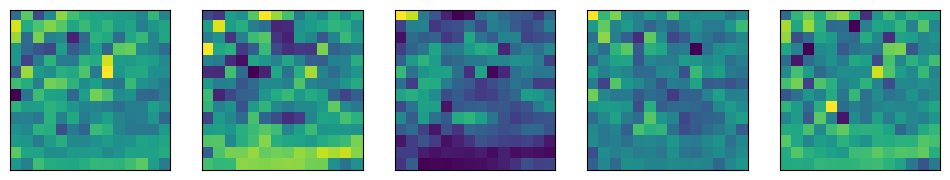

In [17]:
### Lets visualize the feature maps/embeddings from the Conv2d layer

import random

random_indices= random.sample(range(0,768),k=5)

# Create a plot 

fig,axs= plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i,idx in enumerate(random_indices):
    conv_map= embedding[:,idx,:,:]
    axs[i].imshow(conv_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



Text(0.5, 1.0, '1D Feature Map')

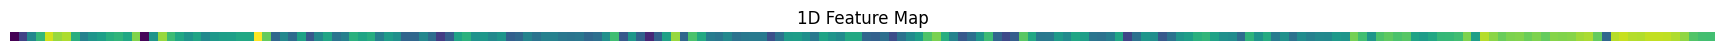

In [18]:
flattened_feature_map= flatten_reshaped[:,:,0]

plt.figure(figsize=(22,22))
plt.imshow(flattened_feature_map.detach().numpy())
plt.axis(False)
plt.title("1D Feature Map")

In [19]:
### Lets create a input embedding layer class by subclassing torch.nn

class embedding_layer(torch.nn.Module):
    
    def __init__(self,input_shape,output_shape,patch_size):
        super().__init__()
        self.out_shape= output_shape
        self.patch_size= patch_size
        self.input_layer_stack = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels=input_shape,
                            out_channels=output_shape,
                            kernel_size=patch_size,
                            stride=patch_size),
                                        
            torch.nn.Flatten(start_dim=2,
                                end_dim=3))
        
    def forward(self,x):
        
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size==0, f"Input image size must be divisble by patch size, image size: {image_resolution}, patch size: {patch_size}"
        fwd= self.input_layer_stack(x)
        change_dim= fwd.permute(0,2,1)
       
        return change_dim
    

In [20]:
embedding_layer= embedding_layer(input_shape=3,output_shape=768,patch_size=16)
embedding_layer_output= embedding_layer(img.unsqueeze(0))
embedding_layer_output.shape

torch.Size([1, 196, 768])

#### Let's create the class token - As per the paper we have to prepend the class token to the path embedding tensor


In [21]:
batch_size= embedding_layer_output.shape[0]
embedding_dimension= embedding_layer_output.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [22]:
class_token= torch.nn.Parameter(torch.randn(batch_size,1,embedding_dimension),requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [23]:
patch_embedding_with_class_token= torch.cat((class_token,embedding_layer_output),dim=1)
patch_embedding_with_class_token.shape 
# after adding the class embedding the embedding dimension went from (1,196,768) -> (1,197,768)

torch.Size([1, 197, 768])

In [24]:
#### Let's create the positional embeddings now

no_of_patches, embedding_dimension

(196, 768)

In [25]:
positional_embedding= torch.nn.Parameter(torch.randn(1,int(no_of_patches+1),embedding_dimension),
                                         requires_grad=True)
positional_embedding.shape

torch.Size([1, 197, 768])

In [26]:
# As per the question lets add the positional embedding to the patch_embedding_with_class_token

final_embedding = patch_embedding_with_class_token + positional_embedding
final_embedding,final_embedding.shape# There wont be any shape change since we are two tensors 

(tensor([[[ 1.9322, -1.4775,  1.4911,  ..., -1.3236,  0.7187,  0.2658],
          [-0.1582,  0.2116,  1.8961,  ...,  0.3316, -0.2234, -1.7577],
          [ 2.4684, -0.6487,  1.8190,  ...,  0.3105, -1.8777,  1.2486],
          ...,
          [-1.2033, -0.0552,  0.3720,  ...,  0.6124, -0.8326, -0.8646],
          [-0.7914,  0.5682,  0.5881,  ...,  1.2789, -0.5884, -0.2298],
          [ 0.6257,  1.7766,  0.7773,  ..., -1.8724, -0.0561, -1.9420]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

##### Now let's put everything together in a single class/ lets put everything in the existing `input_embedding_layer` class

Basic Overview of the Input Embedding Layer ---> [class_token; patch_embeddings]+ positional_embeddings

In [27]:
### Lets create a input embedding layer class by subclassing torch.nn

class input_embedding_layer(torch.nn.Module):
    
    def __init__(self,input_shape,output_shape,patch_size,batch_size,number_of_patches,embedding_dropout):
        super().__init__()

        self.out_shape= output_shape
        self.patch_size= patch_size

        self.input_layer_stack = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels=input_shape,
                            out_channels=output_shape,
                            kernel_size=patch_size,
                            stride=patch_size),
                                        
            torch.nn.Flatten(start_dim=2,
                                end_dim=3))
        
        self.class_token= torch.nn.Parameter(torch.randn(1,batch_size,
                                                         output_shape),
                                                         requires_grad=True)
        
        self.positional_embedding= torch.nn.Parameter(torch.randn(1,int(number_of_patches+1),
                                                                  output_shape),
                                                                  requires_grad=True)
        
        self.embedding_dropout= torch.nn.Dropout(p=embedding_dropout)
        
    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size==0, f"Input image size must be divisble by patch size, image size: {image_resolution}, patch size: {patch_size}"
        fwd= self.input_layer_stack(x)
        change_dim= fwd.permute(0,2,1)
        class_token = self.class_token.expand(batch_size, -1, -1)
        embedding_with_class_token= torch.cat((class_token,change_dim),dim=1)
        embedding_with_pos_embedding = embedding_with_class_token + self.positional_embedding
        embedding_dropout= self.embedding_dropout(embedding_with_pos_embedding)
       
        return embedding_dropout
    

In [28]:
# Let's check our inputs before we pass it into the class

embedding_dropout=0.1

print(f"Embedding Dimension: {embedding_dimension}")
print(f"Patch Size: {patch_size}")
print(f"Batch Size: {batch_size}")
print(f"Number of Patches: {no_of_patches}")
print(f"Embedding Dropout: {embedding_dropout}")

Embedding Dimension: 768
Patch Size: 16
Batch Size: 1
Number of Patches: 196
Embedding Dropout: 0.1


In [29]:
# Instantiate the input embedding layer class 

final_embedding_layer= input_embedding_layer(input_shape=3,output_shape=embedding_dimension,
                                             patch_size=patch_size,batch_size=batch_size,
                                             number_of_patches=no_of_patches,embedding_dropout=embedding_dropout)

In [30]:
# Let's pass in a image tensor and see if everything checks out with the input embedding layer class

embedding_layer_pass= final_embedding_layer(img.unsqueeze(0))
embedding_layer_pass.shape  # Everything checks out and we get the expected embedding output size (1,197,768)

torch.Size([1, 197, 768])

In [31]:
embedding_layer_pass

tensor([[[ 0.0000,  0.8990, -0.9531,  ...,  2.8522, -2.0838,  1.5458],
         [-0.5302, -1.4759,  1.3528,  ...,  1.6515, -1.0315, -2.4363],
         [-0.9076, -0.8582,  1.3652,  ...,  1.2578, -2.0579, -0.4138],
         ...,
         [-0.0559,  0.5729, -0.6146,  ..., -0.1252, -2.4362, -1.3313],
         [-0.7586,  1.3375, -1.1856,  ...,  0.0553,  0.2748,  0.2840],
         [ 0.6527, -0.9799,  0.5551,  ..., -0.0694,  0.7619, -1.4054]]],
       grad_fn=<MulBackward0>)

#### Equation 2: MSA Block

In [32]:
# Lets create the Multi Head Attention Block 
class MultiHeadAttentionBlock(torch.nn.Module):

    def __init__(self,embedding_dim:int,num_heads:int,attention_dropout:int):
        super().__init__()

        # Layer-Norm (LM) layer
        self.layer_norm= torch.nn.LayerNorm(normalized_shape=embedding_dim)

        # Multi Head Attention Layer
        self.multihead_attn= torch.nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attention_dropout,
                                                         batch_first=True)
        
    def forward(self,x):
        # Forward Method
        x= self.layer_norm(x)
        msa_output,_= self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)

        return msa_output

In [33]:
# Instantiate the MSA class above 
num_heads=12
attention_dropout= 0

msa_block = MultiHeadAttentionBlock(embedding_dim=embedding_dimension,
                                    num_heads=num_heads,
                                    attention_dropout=attention_dropout)

In [34]:
## Pass in the output from the input embedding layer for a check
msa_output= msa_block(embedding_layer_pass)

In [35]:
# The shape remains the same, but the values have changed
msa_output.shape

torch.Size([1, 197, 768])

In [36]:
msa_output

tensor([[[ 0.1477, -0.0045, -0.0456,  ...,  0.0368,  0.2294,  0.1256],
         [ 0.1621, -0.0364, -0.0257,  ...,  0.0425,  0.2114,  0.0953],
         [ 0.1434, -0.0228, -0.0276,  ...,  0.0567,  0.2175,  0.1090],
         ...,
         [ 0.1453,  0.0057, -0.0500,  ...,  0.0475,  0.2607,  0.1223],
         [ 0.1874, -0.0414, -0.0591,  ...,  0.0419,  0.2016,  0.1165],
         [ 0.1304, -0.0089, -0.0435,  ...,  0.0495,  0.2412,  0.1222]]],
       grad_fn=<TransposeBackward0>)

In [37]:
## Let's create the MLP block

class MLPBlock(torch.nn.Module):
    def __init__(self,embedding_dim:int,mlp_size:int,dropout:int):

        super().__init__()
        # LN layer
        self.layer_norm= torch.nn.LayerNorm(normalized_shape=embedding_dim)
        # MLP layer with GELU and dropout
        self.mlp_layer= torch.nn.Sequential(torch.nn.Linear(in_features=embedding_dim,out_features=mlp_size),
                                      torch.nn.GELU(),
                                      torch.nn.Dropout(p=dropout),
                                      torch.nn.Linear(in_features=mlp_size,out_features=embedding_dim),
                                      torch.nn.Dropout(p=dropout)
                                      )
    # forward method
    def forward(self,x):
        x= self.layer_norm(x)
        x= self.mlp_layer(x)
        return x

In [38]:
# Instantiate the MLPBlock

mlp_block= MLPBlock(embedding_dim=embedding_dimension,
                    mlp_size=3072,
                    dropout=0.1)

mlp_pass = mlp_block(msa_output) # pass in the output from the MSA block
mlp_pass,mlp_pass.shape

(tensor([[[-0.0349, -0.2896, -0.0230,  ..., -0.1645, -0.2108,  0.1474],
          [ 0.0254, -0.2481,  0.1927,  ..., -0.1132, -0.2903,  0.1775],
          [ 0.1308, -0.1117, -0.0311,  ..., -0.1582, -0.3486,  0.0460],
          ...,
          [-0.0102, -0.0135, -0.0757,  ..., -0.0710, -0.3410,  0.0237],
          [-0.0564, -0.1681,  0.0027,  ..., -0.0115, -0.2861,  0.0000],
          [-0.1409, -0.0000, -0.0616,  ..., -0.0674, -0.4235,  0.2013]]],
        grad_fn=<MulBackward0>),
 torch.Size([1, 197, 768]))

#### Building the Transformer Encoder Block

x_input ---> Embedding Block---> MSA_Block ---> [MSA_block_output + Embedding Block Output] ---> MLP_Block ---> [MLP_Block + MSA_block_output]

In [39]:
class TransformerEncoderBlock(torch.nn.Module):

    def __init__(self,embedding_dim:int,num_heads:int,attention_dropout:int,mlp_size:int,mlp_dropout:int):
        super().__init__()

        self.msa = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            attention_dropout=attention_dropout)
        
        self.mlp= MLPBlock(embedding_dim=embedding_dim,
                           mlp_size=mlp_size,
                           dropout=mlp_dropout)
        
    def forward(self,x):
        x= self.msa(x) +x
        x= self.mlp(x) +x
        return x

In [40]:
transformer_encoder_block = TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                    num_heads=12,attention_dropout=0,
                                                    mlp_size=3072,mlp_dropout=0.1)
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttentionBlock (msa)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [41]:
### Creating the entire ViT architecture

class ViT(torch.nn.Module):

    def __init__(self,input_shape,embedding_dimension,
                 patch_size,batch_size,
                 number_of_patches,num_heads,
                 attention_dropout,embedding_dropout,mlp_size,dropout,num_output_classes,num_transformer_layers):
        
        super().__init__()
        
        # Input Embedding Layer

        self.input_embedding_layer= input_embedding_layer(input_shape=input_shape,
                                                          output_shape=embedding_dimension,
                                                          patch_size=patch_size,
                                                          batch_size=batch_size,
                                                          number_of_patches=number_of_patches,embedding_dropout=embedding_dropout)
        
        self.transformer_encoder_block= torch.nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                                 num_heads=num_heads,
                                                                 attention_dropout=attention_dropout,
                                                                 mlp_size=mlp_size,mlp_dropout=dropout) for _ in range(num_transformer_layers)])
        
        self.classifier = torch.nn.Sequential(torch.nn.LayerNorm(normalized_shape=embedding_dimension),
                                              torch.nn.Linear(in_features=embedding_dimension,
                                                              out_features=num_output_classes))
        
    def forward(self,x):

        x= self.input_embedding_layer(x)
        x= self.transformer_encoder_block(x)
        x= self.classifier(x)

        return x

In [42]:
# Let's check the input arguments before instantiating the ViT class

input_size =3
num_heads=12
attn_dropout=0.1
mlp_size= 3072
dropout= 0.1
num_classes = 3
num_transformer_layers= 12


print(f"Input Size: {input_size}")
print(f"Embedding Size: {embedding_dimension}")
print(f"Patch Size: {patch_size}")
print(f"Batch Size: {batch_size}")
print(f"Number of Patches: {no_of_patches}")
print(f"Number of Attention Heads:{num_heads}")
print(f"Attention Dropout Probability: {attn_dropout}")
print(f"Embedding Dropout: {embedding_dropout}")
print(f"MLP Layer Size: {mlp_size}")
print(f"Dropout Probability For MLP Layer: {dropout}")
print(f"Number of Classes {num_classes}")

Input Size: 3
Embedding Size: 768
Patch Size: 16
Batch Size: 1
Number of Patches: 196
Number of Attention Heads:12
Attention Dropout Probability: 0.1
Embedding Dropout: 0.1
MLP Layer Size: 3072
Dropout Probability For MLP Layer: 0.1
Number of Classes 3


In [43]:
ViT_model = ViT(input_shape=input_size,
                embedding_dimension=embedding_dimension,
                patch_size=patch_size, batch_size=batch_size,
                number_of_patches=no_of_patches,
                num_heads=num_heads,
                attention_dropout=attn_dropout,
                embedding_dropout=embedding_dropout,
                mlp_size=mlp_size,dropout=dropout,
                num_output_classes=num_classes,
                num_transformer_layers=num_transformer_layers
                )

In [44]:
num_classes

3

In [45]:
ViT_model(img.unsqueeze(0)).shape

torch.Size([1, 197, 3])

In [47]:
# sample forward pass on the new ViT class

summary(model=ViT_model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 197, 3]          --                   True
├─input_embedding_layer (input_embedding_layer)              [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Sequential (input_layer_stack)                        [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten (1)                                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder_block)                     [1, 197, 768]        [1, 197, 768] 